# Module System Basics

The module system is the foundation for building neural networks in BrainState. It provides a clean, object-oriented interface for organizing stateful computations.

In this tutorial, you will learn:

- 🏗️ The `Module` base class and its role
- 🔨 How to create custom modules
- 🧩 Module composition and nesting
- 🎯 Parameter management and initialization
- 📦 Working with module hierarchies

## Why Modules?

Modules (via `brainstate.nn.Module`) provide:

✅ **Automatic state management** - States are tracked automatically  
✅ **Clean abstractions** - Encapsulate related computations  
✅ **Reusability** - Build once, use everywhere  
✅ **Composability** - Combine simple modules into complex systems

In [1]:
import brainstate
import jax.numpy as jnp
import matplotlib.pyplot as plt

## 1. The Module Base Class

`brainstate.nn.Module` is the base class for all modules in BrainState. It provides:

- Automatic registration of child modules
- State collection and management
- Pretty printing and inspection
- Integration with JAX transformations

### Creating Your First Module

The simplest module inherits from `Module` and implements `update()`:

In [2]:
class SimpleModule(brainstate.nn.Module):
    """A minimal module that adds a constant."""
    
    def __init__(self, constant=1.0):
        super().__init__()  # Always call parent __init__
        self.constant = constant
    
    def update(self, x):
        return x + self.constant

# Create and use the module
module = SimpleModule(constant=5.0)
result = module(jnp.array([1.0, 2.0, 3.0]))

print("Input:", jnp.array([1.0, 2.0, 3.0]))
print("Output:", result)
print("\nModule:")
print(module)

Input: [1. 2. 3.]
Output: [6. 7. 8.]

Module:
SimpleModule(
  constant=5.0
)


### Adding States to Modules

Modules become powerful when they contain states:

In [3]:
class Counter(brainstate.nn.Module):
    """A module that counts how many times it's called."""
    
    def __init__(self):
        super().__init__()
        # Create a state to track the count
        self.count = brainstate.ShortTermState(jnp.array(0))
    
    def update(self, x):
        # Increment counter
        self.count.value = self.count.value + 1
        # Return input with count
        return x * self.count.value

# Test the counter
counter = Counter()
print("Initial count:", counter.count.value)

for i in range(5):
    result = counter(jnp.array(10.0))
    print(f"Call {i+1}: count={counter.count.value}, result={result}")

Initial count: 0
Call 1: count=1, result=10.0
Call 2: count=2, result=20.0
Call 3: count=3, result=30.0
Call 4: count=4, result=40.0
Call 5: count=5, result=50.0


## 2. Creating Custom Modules

Let's build a complete linear layer from scratch to understand module design:

### Example: Custom Linear Layer

In [4]:
class Linear(brainstate.nn.Module):
    """A linear transformation: y = W @ x + b"""
    
    def __init__(self, in_features, out_features, use_bias=True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        
        # Initialize weight with Xavier/Glorot initialization
        std = jnp.sqrt(2.0 / (in_features + out_features))
        self.weight = brainstate.ParamState(
            brainstate.random.randn(in_features, out_features) * std
        )
        
        # Initialize bias to zero
        if use_bias:
            self.bias = brainstate.ParamState(jnp.zeros(out_features))
    
    def update(self, x):
        """Forward pass.
        
        Args:
            x: Input tensor of shape (..., in_features)
            
        Returns:
            Output tensor of shape (..., out_features)
        """
        out = x @ self.weight.value
        if self.use_bias:
            out = out + self.bias.value
        return out
    
    def __repr__(self):
        return f"Linear(in_features={self.in_features}, out_features={self.out_features}, use_bias={self.use_bias})"

# Create and test the linear layer
brainstate.random.seed(42)
linear = Linear(in_features=5, out_features=3)

# Forward pass
x = jnp.ones(5)
y = linear(x)

print("Module:")
print(linear)
print(f"\nWeight shape: {linear.weight.value.shape}")
print(f"Bias shape: {linear.bias.value.shape}")
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output: {y}")

Module:
Linear(in_features=5, out_features=3, use_bias=True)

Weight shape: (5, 3)
Bias shape: (3,)

Input shape: (5,)
Output shape: (3,)
Output: [ 0.3793956  -0.9351347  -0.94997764]


### Example: Custom Activation Module

Activation: LeakyReLU(negative_slope=0.1)
Input:  [-2. -1.  0.  1.  2.]
Output: [-0.2 -0.1  0.   1.   2. ]


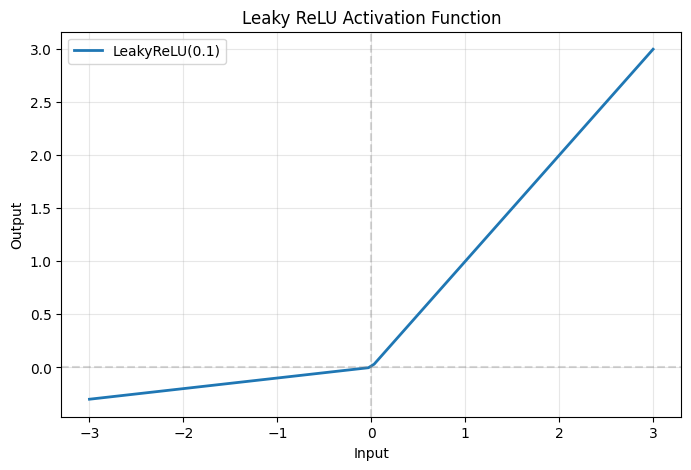

In [5]:
class LeakyReLU(brainstate.nn.Module):
    """Leaky ReLU activation: y = max(alpha * x, x)"""
    
    def __init__(self, negative_slope=0.01):
        super().__init__()
        self.negative_slope = negative_slope
    
    def update(self, x):
        return jnp.where(x > 0, x, self.negative_slope * x)
    
    def __repr__(self):
        return f"LeakyReLU(negative_slope={self.negative_slope})"

# Test the activation
activation = LeakyReLU(negative_slope=0.1)
x = jnp.array([-2.0, -1.0, 0.0, 1.0, 2.0])
y = activation(x)

print("Activation:", activation)
print(f"Input:  {x}")
print(f"Output: {y}")

# Visualize
x_plot = jnp.linspace(-3, 3, 100)
y_plot = activation(x_plot)

plt.figure(figsize=(8, 5))
plt.plot(x_plot, y_plot, linewidth=2, label='LeakyReLU(0.1)')
plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(0, color='gray', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Leaky ReLU Activation Function')
plt.legend()
plt.show()

## 3. Module Composition and Nesting

The real power of modules comes from composing them into larger networks.

### Sequential Composition

Build a network by stacking layers sequentially:

In [6]:
class MLP(brainstate.nn.Module):
    """Multi-layer perceptron with customizable architecture."""
    
    def __init__(self, layer_sizes, activation='relu'):
        super().__init__()
        
        self.layers = []
        
        # Create layers
        for i in range(len(layer_sizes) - 1):
            # Add linear layer
            layer = Linear(layer_sizes[i], layer_sizes[i+1])
            setattr(self, f'layer_{i}', layer)  # Register as attribute
            self.layers.append(layer)
            
            # Add activation (except for last layer)
            if i < len(layer_sizes) - 2:
                if activation == 'relu':
                    act = LeakyReLU(negative_slope=0.0)  # Standard ReLU
                else:
                    act = LeakyReLU(negative_slope=0.01)
                setattr(self, f'activation_{i}', act)
                self.layers.append(act)
    
    def update(self, x):
        """Forward pass through all layers."""
        for layer in self.layers:
            x = layer(x)
        return x

# Create a 3-layer MLP
brainstate.random.seed(0)
mlp = MLP(layer_sizes=[10, 64, 32, 5])

# Forward pass
x = brainstate.random.randn(10)
y = mlp(x)

print("MLP Architecture:")
print(mlp)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output: {y}")

MLP Architecture:
MLP(
  layers=[
    Linear(in_features=10, out_features=64, use_bias=True),
    LeakyReLU(negative_slope=0.0),
    Linear(in_features=64, out_features=32, use_bias=True),
    LeakyReLU(negative_slope=0.0),
    Linear(in_features=32, out_features=5, use_bias=True)
  ],
  layer_0=Linear(in_features=10, out_features=64, use_bias=True),
  activation_0=LeakyReLU(negative_slope=0.0),
  layer_1=Linear(in_features=64, out_features=32, use_bias=True),
  activation_1=LeakyReLU(negative_slope=0.0),
  layer_2=Linear(in_features=32, out_features=5, use_bias=True)
)

Input shape: (10,)
Output shape: (5,)
Output: [-0.49218872  0.5558434  -0.6296929   0.25295696  0.37388656]


### Residual Connections

Implement skip connections for deeper networks:

In [7]:
class ResidualBlock(brainstate.nn.Module):
    """Residual block: y = F(x) + x"""
    
    def __init__(self, dim):
        super().__init__()
        
        # Two linear layers with activation in between
        self.linear1 = Linear(dim, dim)
        self.activation = LeakyReLU(0.0)
        self.linear2 = Linear(dim, dim)
    
    def update(self, x):
        # Compute residual
        residual = x
        
        # Forward through layers
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)
        
        # Add residual
        return out + residual

class ResNet(brainstate.nn.Module):
    """Simple ResNet with multiple residual blocks."""
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_blocks=3):
        super().__init__()
        
        # Input projection
        self.input_proj = Linear(input_dim, hidden_dim)
        
        # Residual blocks
        self.blocks = []
        for i in range(n_blocks):
            block = ResidualBlock(hidden_dim)
            setattr(self, f'block_{i}', block)
            self.blocks.append(block)
        
        # Output projection
        self.output_proj = Linear(hidden_dim, output_dim)
    
    def update(self, x):
        # Project to hidden dimension
        x = self.input_proj(x)
        
        # Pass through residual blocks
        for block in self.blocks:
            x = block(x)
        
        # Project to output
        x = self.output_proj(x)
        return x

# Create ResNet
brainstate.random.seed(0)
resnet = ResNet(input_dim=10, hidden_dim=32, output_dim=5, n_blocks=3)

# Forward pass
x = brainstate.random.randn(10)
y = resnet(x)

print("ResNet:")
print(resnet)
print(f"\nOutput shape: {y.shape}")

ResNet:
ResNet(
  input_proj=Linear(in_features=10, out_features=32, use_bias=True),
  blocks=[
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    ),
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    ),
    ResidualBlock(
      linear1=Linear(in_features=32, out_features=32, use_bias=True),
      activation=LeakyReLU(negative_slope=0.0),
      linear2=Linear(in_features=32, out_features=32, use_bias=True)
    )
  ],
  block_0=ResidualBlock(...),
  block_1=ResidualBlock(...),
  block_2=ResidualBlock(...),
  output_proj=Linear(in_features=32, out_features=5, use_bias=True)
)

Output shape: (5,)


## 4. Parameter Management

### Counting Parameters

In [8]:
def count_parameters(module):
    """Count total number of parameters in a module."""
    total = 0
    
    # Use StateTraceStack to find all states
    with brainstate.StateTraceStack() as stack:
        # Do a dummy forward pass to trigger state access
        try:
            if hasattr(module, 'in_features'):
                dummy_input = jnp.zeros(module.in_features)
            elif hasattr(module, 'input_proj'):
                dummy_input = jnp.zeros(module.input_proj.in_features)
            else:
                dummy_input = jnp.zeros(10)
            module(dummy_input)
        except:
            pass
        
        # Count parameters from read states
        for state in stack.get_read_states():
            if isinstance(state, brainstate.ParamState):
                if hasattr(state.value, 'size'):
                    total += state.value.size
    
    return total

# Count parameters in different modules
print("Parameter Counts:")
print(f"Linear(5→3): {count_parameters(linear):,} parameters")
print(f"MLP: {count_parameters(mlp):,} parameters")
print(f"ResNet: {count_parameters(resnet):,} parameters")

Parameter Counts:
Linear(5→3): 18 parameters
MLP: 2,949 parameters
ResNet: 6,853 parameters


### Custom Initialization

You can customize how parameters are initialized:

In [9]:
class LinearWithCustomInit(brainstate.nn.Module):
    """Linear layer with customizable initialization."""
    
    def __init__(self, in_features, out_features, init_method='xavier'):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize based on method
        if init_method == 'xavier':
            # Xavier/Glorot initialization
            std = jnp.sqrt(2.0 / (in_features + out_features))
            w = brainstate.random.randn(in_features, out_features) * std
        elif init_method == 'he':
            # He initialization (for ReLU)
            std = jnp.sqrt(2.0 / in_features)
            w = brainstate.random.randn(in_features, out_features) * std
        elif init_method == 'uniform':
            # Uniform initialization
            bound = jnp.sqrt(6.0 / (in_features + out_features))
            w = brainstate.random.uniform(-bound, bound, (in_features, out_features))
        elif init_method == 'zeros':
            w = jnp.zeros((in_features, out_features))
        else:
            raise ValueError(f"Unknown init method: {init_method}")
        
        self.weight = brainstate.ParamState(w)
        self.bias = brainstate.ParamState(jnp.zeros(out_features))
    
    def update(self, x):
        return x @ self.weight.value + self.bias.value

# Compare different initializations
brainstate.random.seed(42)
methods = ['xavier', 'he', 'uniform', 'zeros']
layers = {}

print("Weight Statistics for Different Initializations:\n")
for method in methods:
    brainstate.random.seed(42)  # Same seed for fair comparison
    layer = LinearWithCustomInit(100, 100, init_method=method)
    layers[method] = layer
    
    w = layer.weight.value
    print(f"{method:8s}: mean={jnp.mean(w):7.4f}, std={jnp.std(w):7.4f}, "
          f"min={jnp.min(w):7.4f}, max={jnp.max(w):7.4f}")

Weight Statistics for Different Initializations:

xavier  : mean=-0.0001, std= 0.1002, min=-0.3556, max= 0.3646
he      : mean=-0.0002, std= 0.1418, min=-0.5029, max= 0.5157
uniform : mean=-0.0001, std= 0.1002, min=-0.1731, max= 0.1732
zeros   : mean= 0.0000, std= 0.0000, min= 0.0000, max= 0.0000


## 5. Practical Example: Building a Classifier

Let's put everything together to build a complete classifier:

In [11]:
class Classifier(brainstate.nn.Module):
    """A complete classifier with feature extraction and classification head."""
    
    def __init__(self, input_dim, hidden_dims, num_classes, dropout_rate=0.5):
        super().__init__()
        
        # Feature extractor (backbone)
        self.backbone = MLP([input_dim] + hidden_dims, activation='relu')
        
        # Classification head
        self.classifier = Linear(hidden_dims[-1], num_classes)
        
        # Dropout for regularization
        self.dropout_rate = dropout_rate
        self.training = brainstate.ShortTermState(True)
    
    def dropout(self, x):
        """Apply dropout if in training mode."""
        if not self.training.value:
            return x
        
        keep_prob = 1.0 - self.dropout_rate
        mask = brainstate.random.bernoulli(keep_prob, x.shape)
        return x * mask / keep_prob
    
    def update(self, x):
        # Extract features
        features = self.backbone(x)
        
        # Apply dropout
        features = self.dropout(features)
        
        # Classify
        logits = self.classifier(features)
        
        return logits
    
    def train_mode(self):
        """Set to training mode."""
        self.training.value = True
    
    def eval_mode(self):
        """Set to evaluation mode."""
        self.training.value = False

# Create classifier
brainstate.random.seed(42)
classifier = Classifier(
    input_dim=784,      # MNIST-like input
    hidden_dims=[256, 128],
    num_classes=10,
    dropout_rate=0.5
)

print("Classifier:")
print(classifier)

# Test in training mode
classifier.train_mode()
x = brainstate.random.randn(784)
logits_train = classifier(x)

print(f"\n[Training Mode]")
print(f"Input shape: {x.shape}")
print(f"Logits shape: {logits_train.shape}")
print(f"Logits: {logits_train}")

# Test in eval mode
classifier.eval_mode()
logits_eval = classifier(x)

print(f"\n[Eval Mode]")
print(f"Logits: {logits_eval}")
print(f"\nNote: Outputs differ due to dropout in training mode")

Classifier:
Classifier(
  backbone=MLP(
    layers=[
      Linear(in_features=784, out_features=256, use_bias=True),
      LeakyReLU(negative_slope=0.0),
      Linear(in_features=256, out_features=128, use_bias=True)
    ],
    layer_0=Linear(in_features=784, out_features=256, use_bias=True),
    activation_0=LeakyReLU(negative_slope=0.0),
    layer_1=Linear(in_features=256, out_features=128, use_bias=True)
  ),
  classifier=Linear(in_features=128, out_features=10, use_bias=True),
  dropout_rate=0.5,
  training=ShortTermState(
    value=ShapedArray(bool[])
  )
)

[Training Mode]
Input shape: (784,)
Logits shape: (10,)
Logits: [ 1.6196028   1.2185875   2.0592844  -1.3224362   0.33283058 -0.3393689
 -0.06156373 -1.8458518   0.60722184  1.1007603 ]

[Eval Mode]
Logits: [ 0.27120447  1.7657112   0.6646653  -1.2513794  -2.046931   -0.36581615
  0.01931907 -1.5779355   0.9222733   0.93361515]

Note: Outputs differ due to dropout in training mode


## Summary

In this tutorial, you learned:

✅ **Module base class** - Foundation for all modules  
✅ **Custom modules** - Creating layers from scratch  
✅ **Composition** - Building complex networks from simple modules  
✅ **Residual connections** - Skip connections for deeper networks  
✅ **Parameter management** - Initialization, counting, and freezing  
✅ **Complete example** - Full classifier with feature extraction  

### Key Principles

1. 🏗️ **Always inherit from `brainstate.nn.Module`**
2. 🔧 **Call `super().__init__()` in your constructor**
3. 📦 **Use `ParamState` for trainable parameters**
4. 🎯 **Register child modules as attributes**
5. 🔄 **Implement `update()` for forward computation**

### Best Practices

- ✨ Use descriptive names for layers and states
- 📝 Document the input/output shapes in docstrings
- 🎨 Implement `__repr__` for better debugging
- 🔍 Use proper initialization for different activation functions
- 🧪 Test modules independently before composition

### Next Steps

Continue with:
- **Basic Layers** - Pre-built layers (Linear, Conv, Pooling)
- **Activations & Normalization** - Activation functions and normalization layers
- **Recurrent Networks** - RNN, LSTM, GRU for sequences
- **Training** - Gradient computation and optimization